# Imports and data loading

In [1]:
import bayesian_multitarget_latent_factors as bmlf
import arviz as az

doInference = False # if False just do the analysis of the idata.nc file

data_dic, test_xr = \
bmlf.dataset_generator(215, n_train_samples=150, )

# Generate inference data netCDF file

In [2]:
if doInference:
    idata = \
    bmlf.sample_from_posterior(data_dic, 1997, output_dir='./01_bspline_generated_example', X_test = test_xr['X_test'].values)
    
    az.to_netcdf(idata, './01_bspline_generated_example/idata.nc')

    raise Exception("Stop the execution here!")

# Explore the inference data file

In [3]:
from bspline_generated_plotting import *
import numpy as np
from bayesian_multitarget_latent_factors.HMC_helper import get_expected_log_likelihood
from ipywidgets import interact, widgets

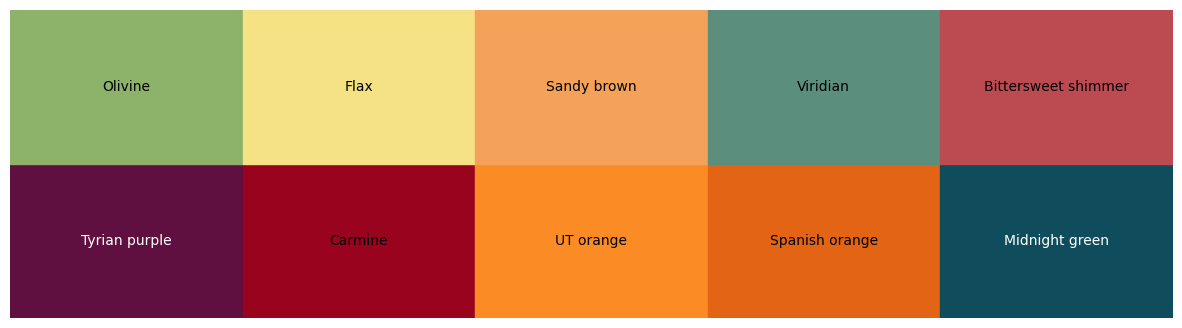

In [4]:
show_palette()

In [5]:
idata = az.from_netcdf("./01_bspline_generated_example/idata.nc")

In [6]:
get_expected_log_likelihood(idata, ['y_posterior'])

-16596.05275714432

In [7]:
get_expected_log_likelihood(idata, ['y_prior'])

-20813.046864956035

In [8]:
Varimax_res_xr = bmlf.Varimax_RSP(idata)

Rotated sample 0
Rotated sample 500
Rotated sample 1000
Rotated sample 1500
Rotated sample 2000
Rotated sample 2500
Rotated sample 3000
Rotated sample 3500
Starting iteration number 0
	 Previous objective fun =	inf
	 New objective fun =		134892.289
Starting iteration number 1
	 Previous objective fun =	134892.289
	 New objective fun =		28934.319
Starting iteration number 2
	 Previous objective fun =	28934.319
	 New objective fun =		28664.334
Starting iteration number 3
	 Previous objective fun =	28664.334
	 New objective fun =		28648.400
Starting iteration number 4
	 Previous objective fun =	28648.400
	 New objective fun =		28642.781
Starting iteration number 5


In [9]:
def plot_Y_wrapper_global(rng_seed, same_sample=True, sample_ul=0, sample_ur=0, sample_ll=0, sample_lr=0, 
                          target_ul=1, target_ur=2, target_ll=1, target_lr=2,
                          req_ul='predictive', req_ur='predictive', req_ll='predictive', req_lr='predictive',
                          conditional_ul=False, conditional_ur=False, conditional_ll=True, conditional_lr=True,
                          sharey='col'):
    
    plot_Y_wrapper(rng_seed=rng_seed, same_sample=same_sample, idata=idata, test_xr=test_xr, 
                   sample_ul=sample_ul, sample_ur=sample_ur, sample_ll=sample_ll, sample_lr=sample_lr, 
                   target_ul=target_ul, target_ur=target_ur, target_ll=target_ll, target_lr=target_lr,
                   req_ul=req_ul, req_ur=req_ur, req_ll=req_ll, req_lr=req_lr,
                   conditional_ul=conditional_ul, conditional_ur=conditional_ur, 
                   conditional_ll=conditional_ll, conditional_lr=conditional_lr,
                   sharey=sharey)

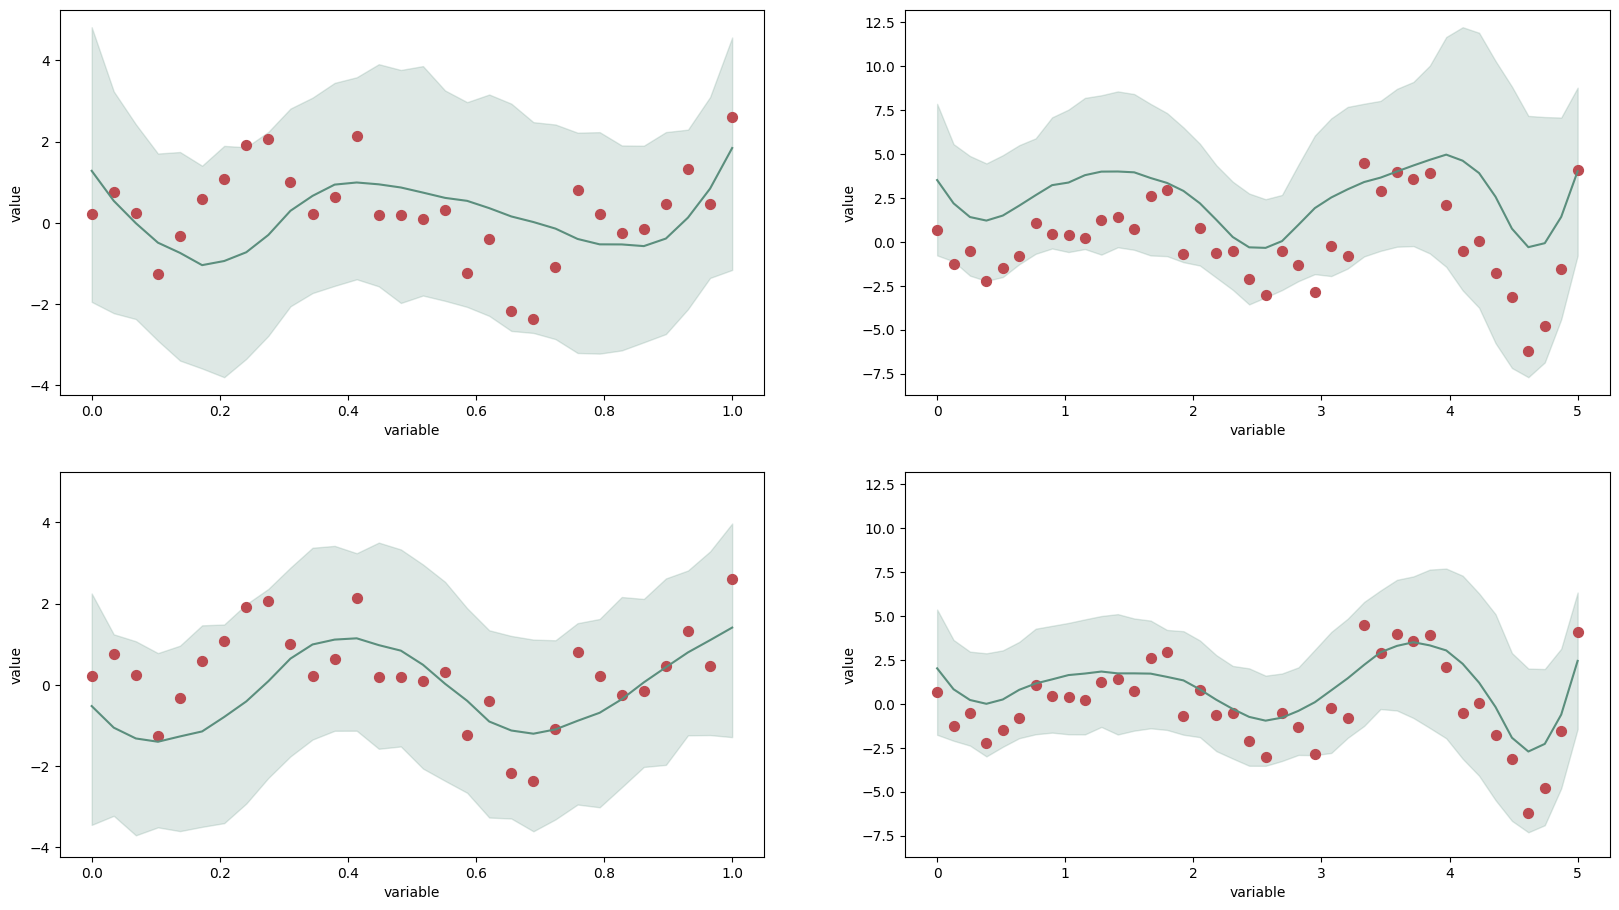

In [10]:
plot_Y_wrapper_global(123, sample_ul=19)

In [11]:
N = test_xr.sizes['X_test_dim_1']

interact(plot_Y_wrapper_global, rng_seed=widgets.IntSlider(min=1, max=500, step=1, value=123),
         sample_ul = range(N), sample_ur = range(N),
         sample_ll = range(N), sample_lr = range(N),
         target_ul = [1,2], target_ur = [1,2],
         target_ll = [1,2], target_lr = [1,2],
         req_ul = ['predictive','predictive idiosyncratic','predictive estimate'],
         req_ur = ['predictive','predictive idiosyncratic','predictive estimate'],
         req_ll = ['predictive','predictive idiosyncratic','predictive estimate'],
         req_lr = ['predictive','predictive idiosyncratic','predictive estimate'],
         sharey = ['none','row','col','all']
        )


interactive(children=(IntSlider(value=123, description='rng_seed', max=500, min=1), Checkbox(value=True, descr…

<function __main__.plot_Y_wrapper_global(rng_seed, same_sample=True, sample_ul=0, sample_ur=0, sample_ll=0, sample_lr=0, target_ul=1, target_ur=2, target_ll=1, target_lr=2, req_ul='predictive', req_ur='predictive', req_ll='predictive', req_lr='predictive', conditional_ul=False, conditional_ur=False, conditional_ll=True, conditional_lr=True, sharey='col')>

In [12]:
def plot_heatmap_regression_global(pointwise = False, known_target = 1):
    plot_heatmap_regression(idata, pointwise, known_target)

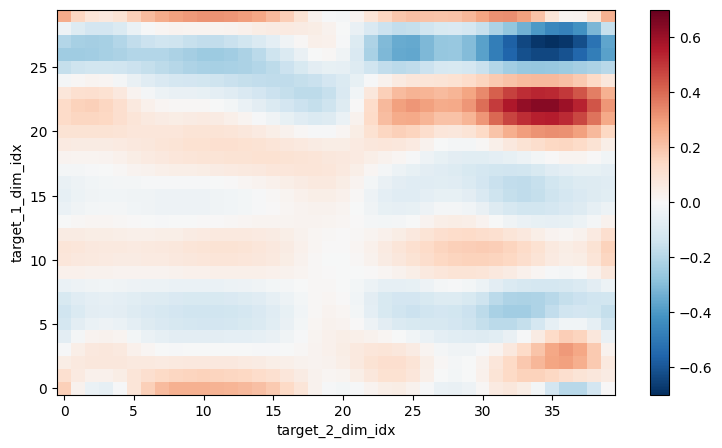

In [13]:
plot_heatmap_regression_global()

In [14]:
interact(plot_heatmap_regression_global, pointwise = False, known_target = [1,2])

interactive(children=(Checkbox(value=False, description='pointwise'), Dropdown(description='known_target', opt…

<function __main__.plot_heatmap_regression_global(pointwise=False, known_target=1)>

In [15]:
def plot_regression_by_PCA_global(pointwise = False, known_target = 1):
    plot_regression_by_PCA(idata, n_components = 3, pointwise = pointwise, known_target = known_target)

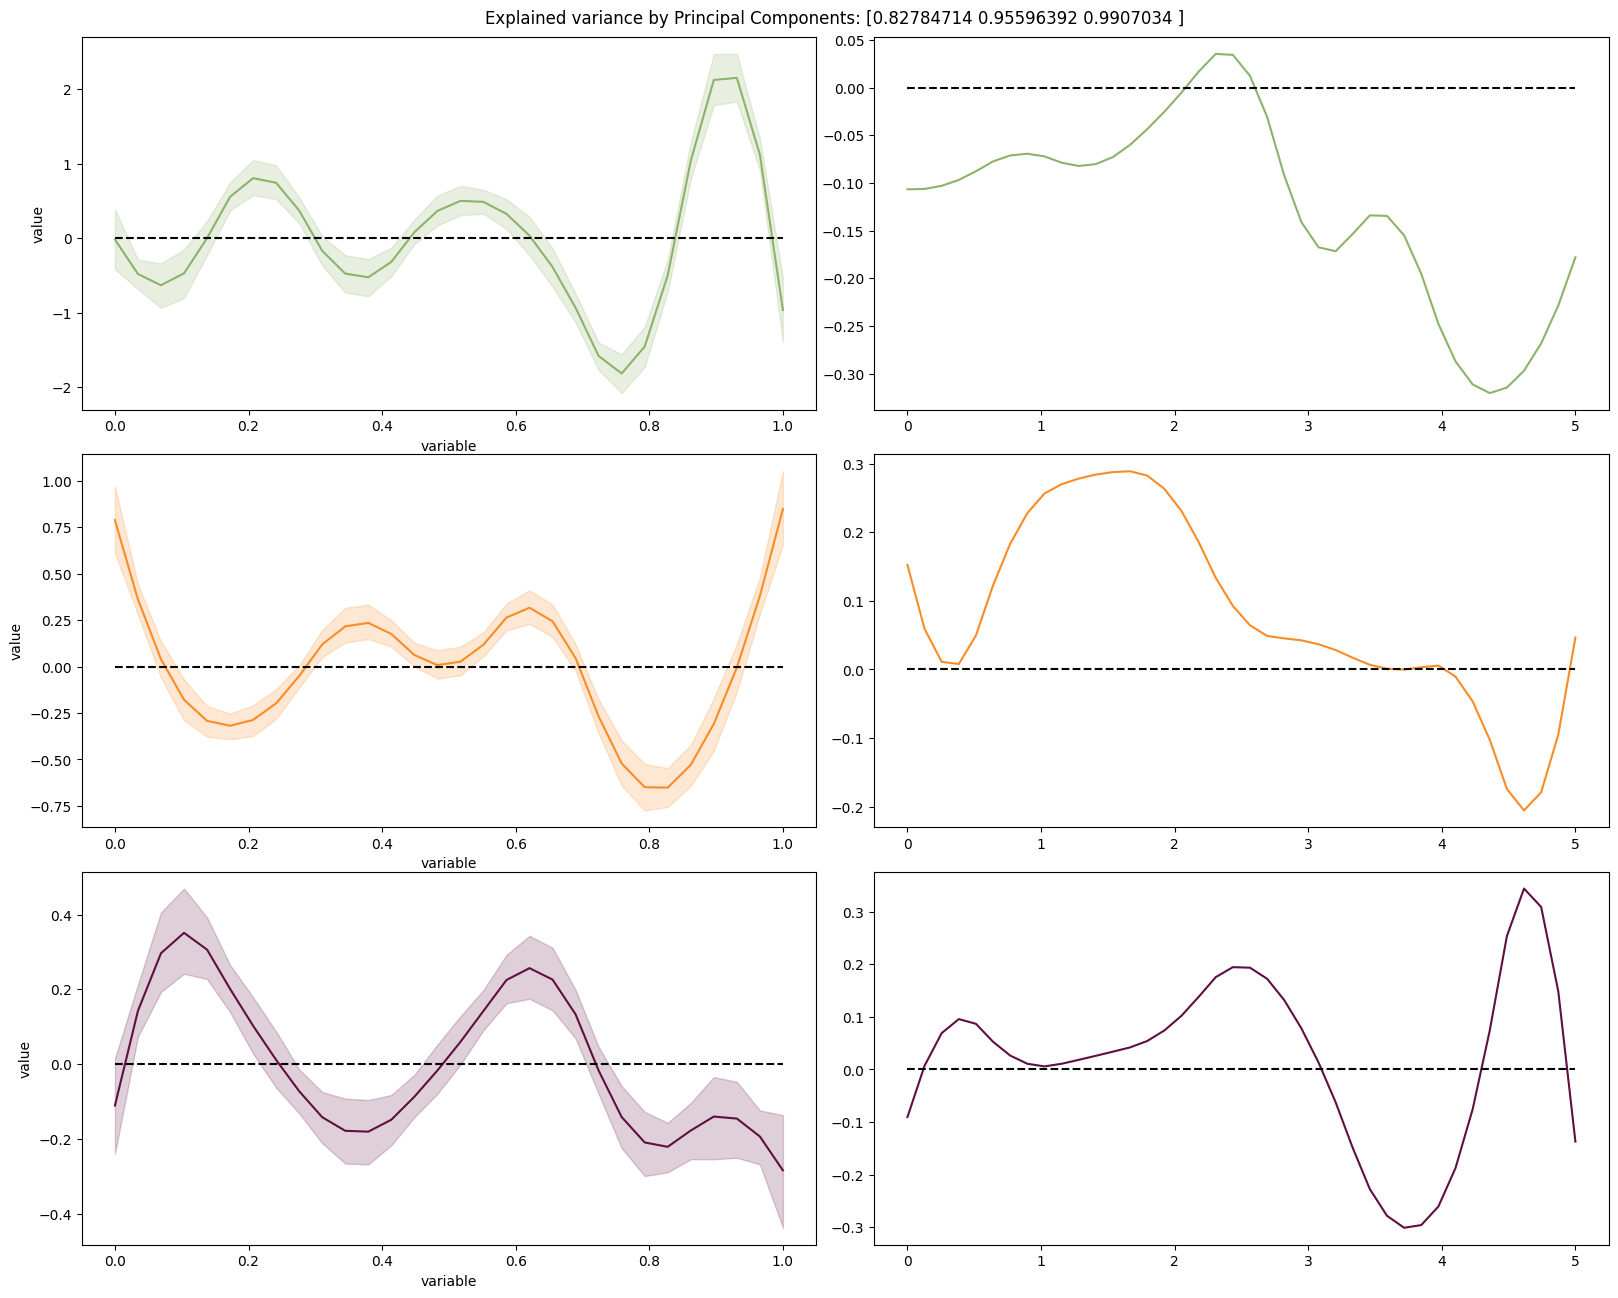

In [16]:
plot_regression_by_PCA_global()

In [17]:
interact(plot_regression_by_PCA_global, pointwise = False, known_target = [1,2])

interactive(children=(Checkbox(value=False, description='pointwise'), Dropdown(description='known_target', opt…

<function __main__.plot_regression_by_PCA_global(pointwise=False, known_target=1)>

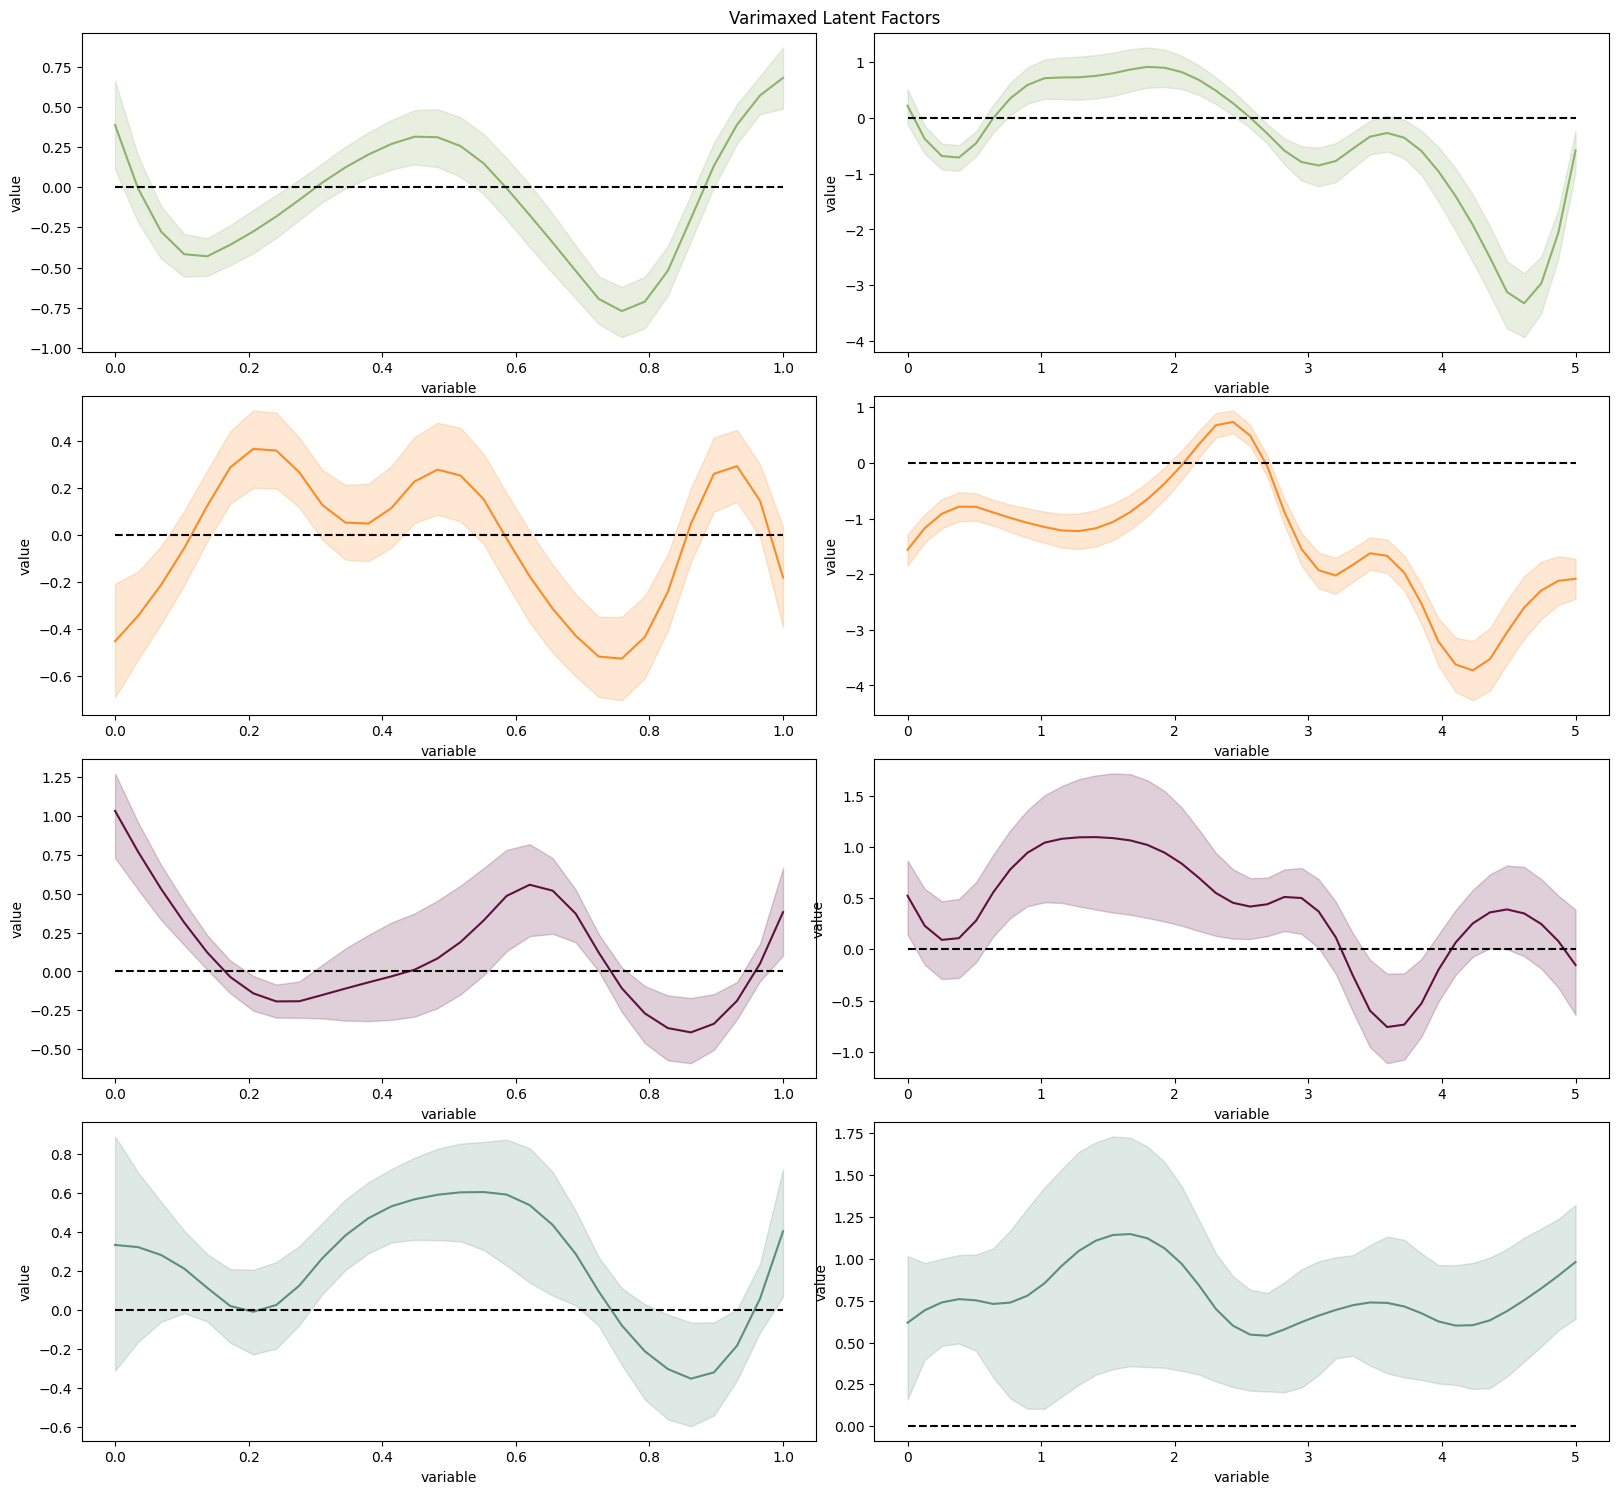

In [18]:
plot_varimaxed_latent_factors(idata, Varimax_res_xr)

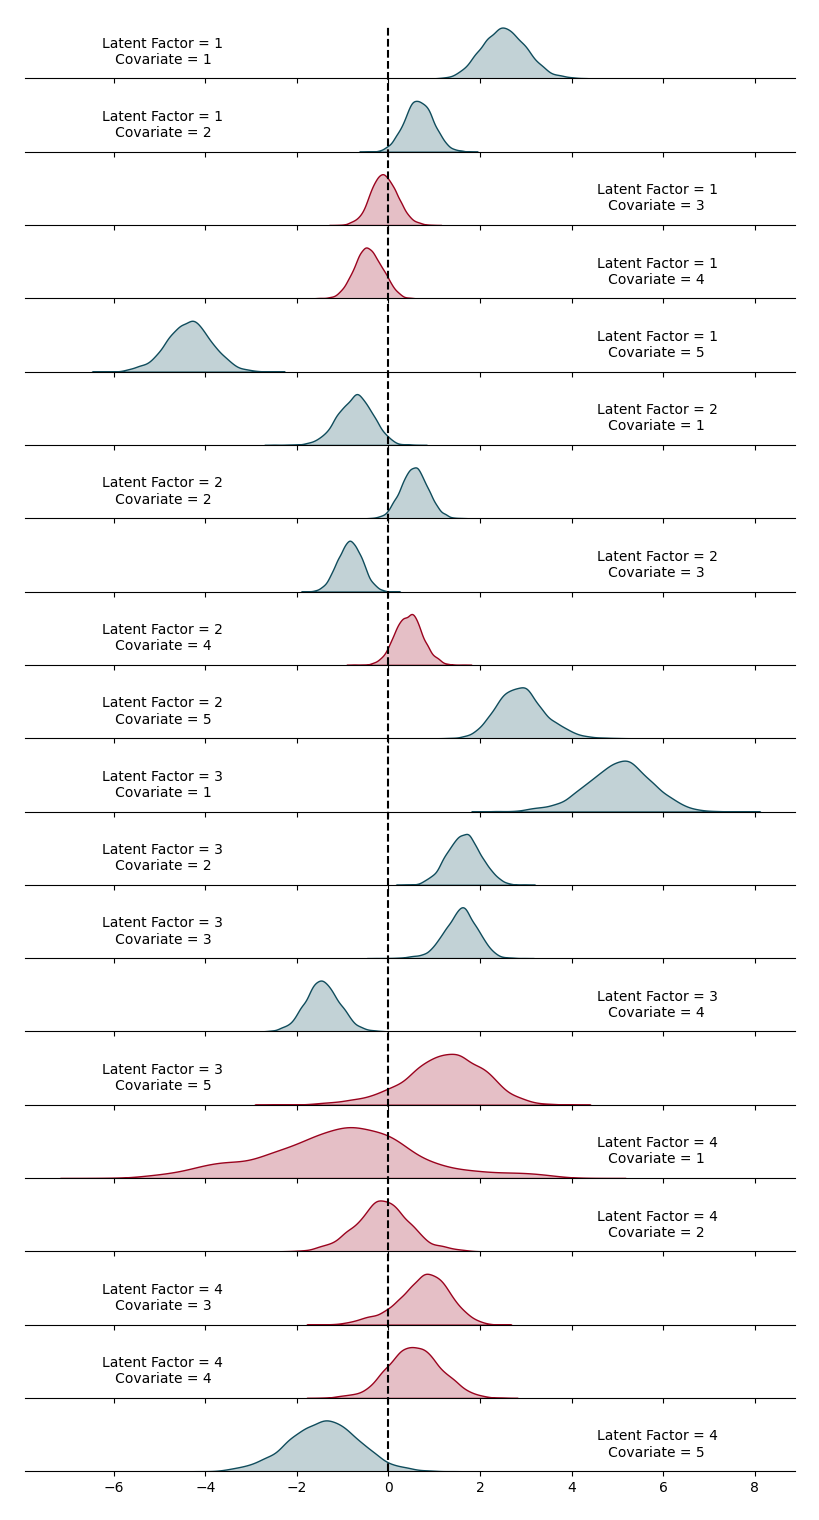

In [19]:
names_array = \
np.array([
    [('latent 1','regr 1'),('latent 2','regr 1'),('latent 3','regr 1'),('latent 4','regr 1')],
    [('latent 1','regr 2'),('latent 2','regr 2'),('latent 3','regr 2'),('latent 4','regr 2')],
    [('latent 1','regr 3'),('latent 2','regr 3'),('latent 3','regr 3'),('latent 4','regr 3')],
    [('latent 1','regr 4'),('latent 2','regr 4'),('latent 3','regr 4'),('latent 4','regr 4')],
    [('latent 1','regr 5'),('latent 2','regr 5'),('latent 3','regr 5'),('latent 4','regr 5')],
])

plot_regression_coefficients(Varimax_res_xr, grid=False)

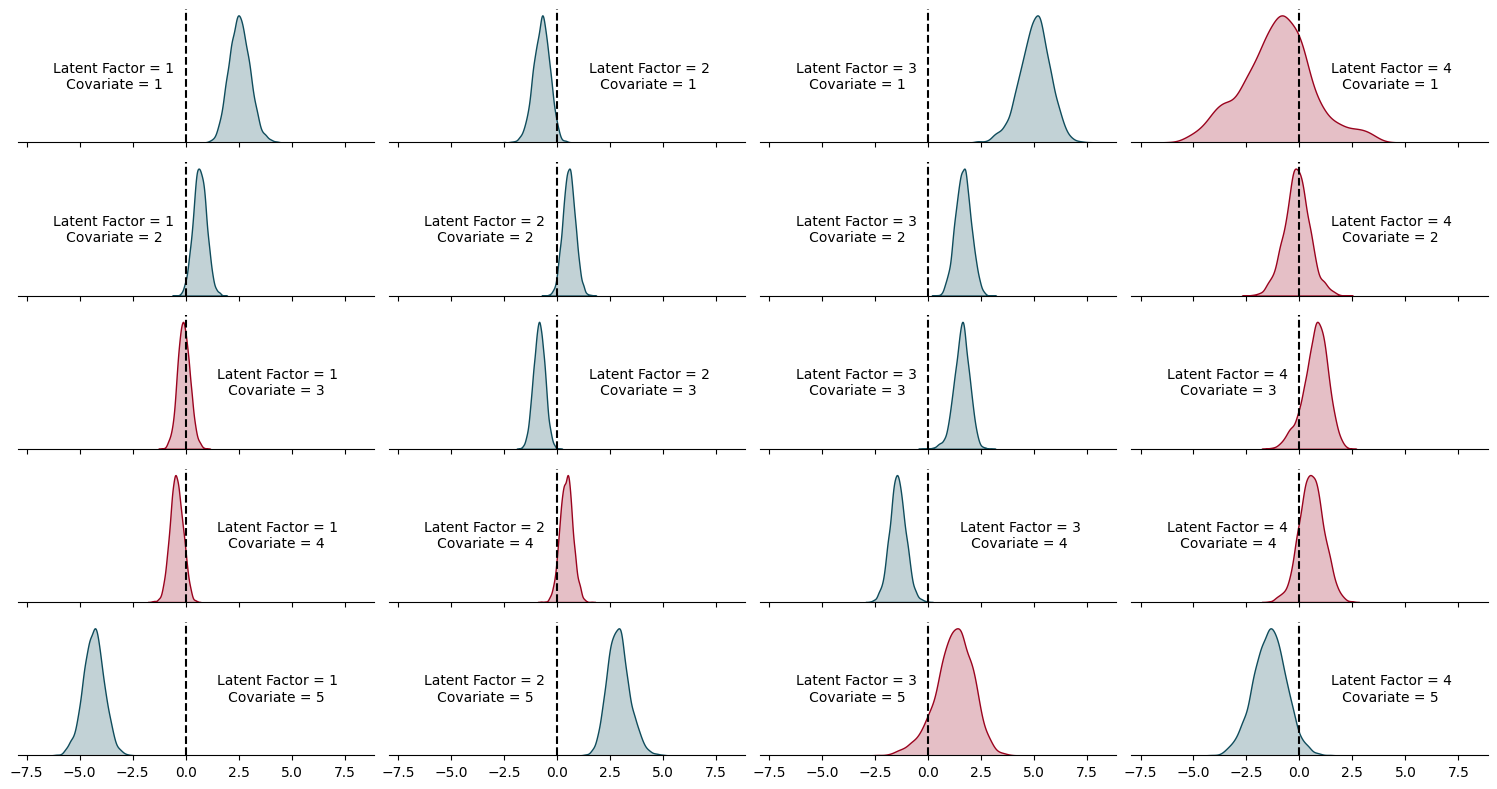

In [20]:
plot_regression_coefficients(Varimax_res_xr)